# **PyCaret**


PyCaret es una biblioteca de código abierto de aprendizaje automático (machine learning) para Python que facilita y agiliza el proceso de desarrollo y experimentación con modelos de aprendizaje automático. Fue desarrollado para simplificar tareas comunes en el flujo de trabajo de aprendizaje automático, como la preparación de datos, la selección de características, la creación de modelos, la evaluación y comparación de modelos, y la interpretación de resultados.

Las características principales de PyCaret son:

* Interfaz sencilla: PyCaret proporciona una interfaz de línea de comandos simple e intuitiva, lo que lo hace accesible incluso para usuarios nuevos en aprendizaje automático.

* Automatización del flujo de trabajo: PyCaret automatiza muchas de las tareas repetitivas y tediosas que generalmente se realizan en el proceso de desarrollo de modelos, lo que permite a los usuarios centrarse más en la experimentación y la iteración rápida.

* Soporte para múltiples bibliotecas de aprendizaje automático: PyCaret es compatible con varias bibliotecas populares de aprendizaje automático, como scikit-learn, XGBoost, LightGBM, CatBoost, etc. Esto permite a los usuarios comparar fácilmente diferentes algoritmos sin necesidad de escribir mucho código.

* Funciones de preprocesamiento de datos: PyCaret ofrece funcionalidades para la preparación y limpieza de datos, incluyendo manejo de valores faltantes, codificación de variables categóricas, y más.

* Comparación de modelos: PyCaret permite comparar rápidamente el rendimiento de varios modelos utilizando diferentes métricas, lo que ayuda a seleccionar el mejor modelo para un problema en particular.

* Sintonización automática de hiperparámetros: PyCaret puede realizar automáticamente la búsqueda de hiperparámetros para optimizar los modelos, lo que reduce la necesidad de ajustar manualmente los hiperparámetros.

* Interpretación de modelos: PyCaret ofrece funciones para interpretar y visualizar los modelos entrenados, lo que facilita la comprensión de cómo funcionan y qué características son más importantes para la predicción.

En general, PyCaret es una excelente herramienta para acelerar y simplificar el proceso de desarrollo de modelos de aprendizaje automático, lo que lo hace especialmente útil para usuarios que deseen experimentar con diferentes algoritmos y técnicas de manera eficiente. Sin embargo, es importante tener en cuenta que, como en cualquier biblioteca de alto nivel, la flexibilidad y control sobre el flujo de trabajo pueden ser más limitados que al utilizar bibliotecas de nivel más bajo como scikit-learn.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Dividir la data en entraniemo y prueba
import statsmodels.api as sms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn import metrics
from skopt import BayesSearchCV
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pycaret
from pycaret.classification import *

import xgboost as xgb
import lightgbm as lgb
import catboost 




import warnings
warnings.filterwarnings("ignore")


def MetricasMatrizConfusion(y,Modelo,X,tipo="ML"):
    ## Validar la longitud de los datos
    if (len(y)==len(X)):
        
        if (tipo!="ML"):
            Probabilidad=Modelo.predict(exog=X) # Logit
            Predicciones=np.where(Probabilidad<0.5,0,1)
        else:
            Predicciones=Modelo.predict(X) # Modleo de ML    
        td1=pd.DataFrame(Predicciones,columns=["Predicciones"])
        td2=pd.concat([y.reset_index(drop=True),td1],axis=1)
        td2.columns=["Realidad","Predicciones"]
        Matriz=pd.crosstab(td2["Realidad"],td2["Predicciones"],margins=True)
        
        ## Formato porcentaje
        MatrizNormalizada=pd.crosstab(td2["Realidad"],td2["Predicciones"],normalize=0)
        sns.heatmap(MatrizNormalizada,annot=True,linewidths = 0.01, cmap = "Blues")
        
        ### Métricas, Recall, Precisión
        
        Accuracy =metrics.accuracy_score(y,Predicciones)
        print(f'Accuracy: {Accuracy}')
        Reporte=metrics.classification_report(y,Predicciones)
        print(f'Reporte : {Reporte}')
        
    
    
    else:
        
        Matriz=[]
        print("Los datos no tienen la misma longitud")
    
    
    return Matriz

def curva_roc(y,Modelo,X,tipo="ML"):
    if (tipo!="ML"):
        Probabilidad=Modelo.predict(exog=X) # Logit (statsmodels)
    else:
        Probabilidad=Modelo.predict_proba(X)[:,1] # cuando es Machine Learning(SKlearn) 
        
    roc_auc=roc_auc_score(y,Probabilidad)
    false_positive,true_positive,limites=roc_curve(y,Probabilidad)
    ramdom_probs=[0 for i in range(len(y))]
    c,d,_=roc_curve(y,ramdom_probs,pos_label=1) ## Diagonal
    
    plt.plot(false_positive,true_positive,linestyle="--",color="green",label="AUC: "+str(round(roc_auc,2)))
    plt.plot(c,d,linestyle="--",color="blue")
    plt.xlabel("Tasa Falsos Positivos")
    plt.ylabel("Tasa Verdaderos Positivos")
    plt.legend()
    plt.show()
    return roc_auc

In [2]:
## Anaconda 
# conda install -c conda-forge pycaret [full]
# conda install -c conda-forge lightgbm
# conda install -c conda-forge catboost
# onda install -c conda-forge xgboost
# conda install -c conda-forge scikit-optimize

In [3]:
## Google colab
# !pip install pycaret[full]
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install scikit-optimize

## **Preparar los datos**

In [4]:
df=pd.read_csv("BaseModelos.csv")

In [5]:
df.head()

,MontoCredito,Edad,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0_-1,...,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,Genero_Homologado_Masculino,EducacionHomologada_Posgrado,EducacionHomologada_Pregrado,EstadoCivilHomologado_Otros,EstadoCivilHomologado_Soltero,Mora
0,20000.0,24.0,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,1,0,1,0,0,1
1,120000.0,26.0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,...,0,0,0,0,1,0,1,0,1,1
2,90000.0,34.0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,...,0,0,0,0,1,0,1,0,1,0
3,50000.0,37.0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,...,0,0,0,0,1,0,1,0,0,0
4,50000.0,57.0,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1,...,0,0,0,0,0,0,1,0,0,0


In [6]:
Cat_Chi2=pd.read_csv("CatSignificativasChi2.csv")["Variable"].tolist()
Num_Anova=pd.read_csv("NumericasSignificativasAnova.csv")["Variable"].tolist()

In [7]:
VariablesPredictivas=Cat_Chi2+Num_Anova

In [8]:
X=df[VariablesPredictivas]

In [9]:
df.rename(columns={"Mora":"target"},inplace=True)

In [10]:
y=df["target"]

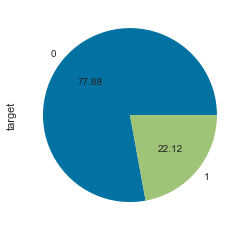

In [11]:
y.value_counts().plot(kind="pie",autopct="%.2f");

In [12]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123, stratify=y)

In [13]:
y_train.value_counts(normalize=True)

0    0.77881
1    0.22119
Name: target, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

0    0.778778
1    0.221222
Name: target, dtype: float64

## **Configuración Pycaret**

In [15]:
pycaret_train=pd.concat([x_train,y_train],axis=1)
pycaret_test=pd.concat([x_test,y_test],axis=1)

In [16]:
#Model=setup(data=pycaret_train,test_data=pycaret_test,target="target",session_id=123,fix_imbalance=True)

In [17]:
#models_to_compare=["rf",'lightgbm','xgboost',"dt","catboost","gbc","lr","et"]

In [18]:
#best_model=compare_models(include=models_to_compare,fold=5,sort="AUC")

In [19]:
#stop

In [20]:
#plot_model(best_model, plot = 'auc')

**Seleccionamos Modelo**

In [21]:
#best_model=create_model("gbc")

In [22]:
#plot_model(best_model,plot="learning")

In [23]:
#plot_model(best_model,plot="feature")

# **La optimización bayesiana**


La optimización bayesiana es un enfoque de optimización que se basa en la inferencia bayesiana y la probabilidad para encontrar la configuración óptima de parámetros de un sistema o función objetivo desconocida. Este enfoque es particularmente útil cuando la evaluación de la función objetivo es costosa o requiere mucho tiempo.

La idea fundamental detrás de la optimización bayesiana es construir un modelo probabilístico de la función objetivo y utilizar este modelo para guiar la búsqueda de la configuración óptima de los parámetros. A medida que se evalúan diferentes configuraciones, el modelo se actualiza con la nueva información, lo que mejora gradualmente la calidad de las predicciones y la búsqueda de la configuración óptima.

In [24]:
#tuned_best_model=tune_model(best_model,search_library="scikit-optimize",return_train_score=True,
#                          fold=3,choose_better=True,optimize="AUC",n_iter=2)

In [25]:
#tuned_best_model

In [26]:
#plot_model(tuned_best_model,plot="learning")

**Entrenamos de forma independiente**

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
ModeloFinal=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [29]:
ModeloFinal.fit(x_train,y_train)

GradientBoostingClassifier(random_state=123)

Accuracy: 0.8261904761904761
Reporte :               precision    recall  f1-score   support

           0       0.84      0.96      0.90     16355
           1       0.70      0.37      0.49      4645

    accuracy                           0.83     21000
   macro avg       0.77      0.66      0.69     21000
weighted avg       0.81      0.83      0.80     21000



Predicciones,0,1,All
Realidad,,,
0,15624,731,16355
1,2919,1726,4645
All,18543,2457,21000


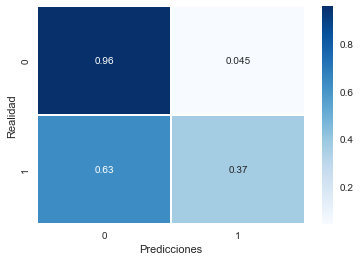

In [30]:
MetricasMatrizConfusion(y=y_train,Modelo=ModeloFinal,X=x_train,tipo="ML")

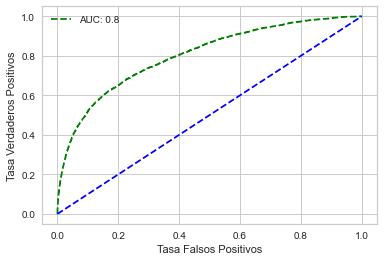

0.802133923749794

In [31]:
curva_roc(y=y_train,Modelo=ModeloFinal,X=x_train,tipo="ML")

Accuracy: 0.822
Reporte :               precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.69      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.82      0.80      9000



Predicciones,0,1,All
Realidad,,,
0,6684,325,7009
1,1277,714,1991
All,7961,1039,9000


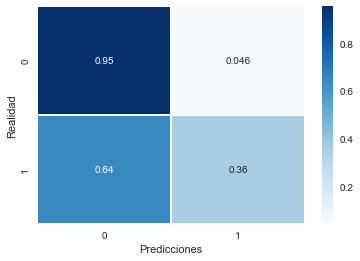

In [32]:
MetricasMatrizConfusion(y=y_test,Modelo=ModeloFinal,X=x_test,tipo="ML")

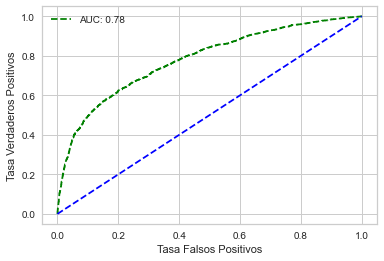

0.7799288551943583

In [33]:
curva_roc(y=y_test,Modelo=ModeloFinal,X=x_test,tipo="ML")

## **Aplicaciones Redes Neuronales**

https://www.tensorflow.org/?hl=es-419

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [35]:
## codificacoón de etiquetas
encoder= LabelEncoder()

In [36]:
y_test=encoder.fit_transform(y_test)
y_train=encoder.fit_transform(y_train)

**La capa de Dropout**

Es una técnica de regularización utilizada en modelos de redes neuronales para prevenir el sobreajuste (overfitting). El sobreajuste ocurre cuando un modelo se adapta demasiado a los datos de entrenamiento y no generaliza bien a nuevos datos. La capa de Dropout aborda este problema apagando aleatoriamente un conjunto fraccionario de unidades de la red durante el entrenamiento, lo que significa que estas unidades no contribuirán a la propagación hacia adelante ni a la propagación hacia atrás durante una iteración específica del entrenamiento.


In [37]:
x_train.shape[1]

63

In [38]:
## Definir el Modelo
model=Sequential()
model.add(Dense(63,input_dim=x_train.shape[1],activation="relu")) ## Capa de Entrada
model.add(Dropout(0.2)) # Capa de Dropout
## Capa Oculta 1
model.add(Dense(30,activation="relu")) 
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(15,activation="relu")) 
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(8,activation="relu")) 
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(4,activation="relu")) 
model.add(Dropout(0.2)) # Capa de Dropout
## Capa Oculta 1
model.add(Dense(2,activation="relu")) 
model.add(Dropout(0.2)) # Capa de Dropout
## Capa Salida
model.add(Dense(1,activation="sigmoid"))

2023-11-29 20:01:18.545214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


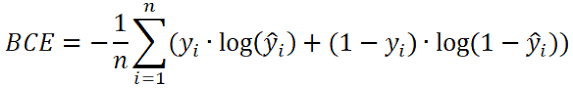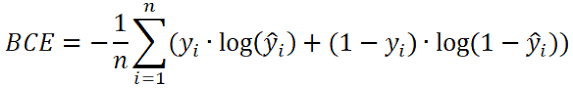

In [39]:
## Compilar el modelo
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01),metrics=["AUC"])

In [40]:
## Entrenamiento
model.fit(x_train,y_train,validation_split=0.2,epochs=100)

Epoch 1/100
525/525 [==============================] - 2s 2ms/step - loss: 0.5434 - auc: 0.5023 - val_loss: 0.5299 - val_auc: 0.5000
Epoch 2/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5282 - auc: 0.4920 - val_loss: 0.5300 - val_auc: 0.5000
Epoch 3/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5282 - auc: 0.5000 - val_loss: 0.5309 - val_auc: 0.5000
Epoch 4/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5283 - auc: 0.4976 - val_loss: 0.5299 - val_auc: 0.5000
Epoch 5/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5282 - auc: 0.4986 - val_loss: 0.5299 - val_auc: 0.5000
Epoch 6/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5283 - auc: 0.4953 - val_loss: 0.5301 - val_auc: 0.5000
Epoch 7/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5282 - auc: 0.5010 - val_loss: 0.5300 - val_auc: 0.5000
Epoch 8/100
525/525 [==============================] - 1s 1ms/step - 

In [41]:
from tensorflow.keras.utils import plot_model
#conda install -c conda-forge pydot

In [42]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
probabilidades=model.predict(x_test)

282/282 [==============================] - 0s 622us/step


In [44]:
probabilidades

array([[0.22650097],
       [0.22650097],
       [0.22650097],
       ...,
       [0.22650097],
       [0.22650097],
       [0.22650097]], dtype=float32)

In [45]:
## Clasifcacion
Predicciones=np.where(probabilidades<0.5,0,1)
Predicciones

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [46]:
Reporte=metrics.classification_report(y_test,Predicciones)
print(Reporte)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7009
           1       0.00      0.00      0.00      1991

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000



0.5


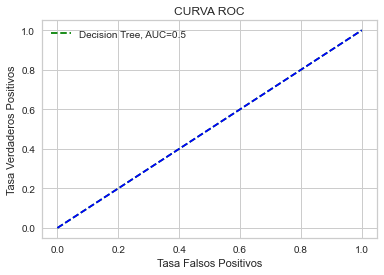

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, probabilidades[:,0])
AUC_RN=round(roc_auc_score(y_test,  probabilidades[:,0]),2)
print(AUC_RN)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr,tpr,linestyle="--",color="green",label="Decision Tree, AUC="+str(AUC_RN))
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title("CURVA ROC")
plt.xlabel("Tasa Falsos Positivos")
plt.ylabel("Tasa Verdaderos Positivos")
plt.legend()
plt.show()

## **Presentación Empresa**

In [48]:
ModeloFinal

GradientBoostingClassifier(random_state=123)

## **Shap Values**

In [49]:
import shap
# conda install -c anaconda shap
# !pip install shap

In [50]:
pred=ModeloFinal.predict(x_train)

In [51]:
explainer=shap.TreeExplainer(ModeloFinal)

In [52]:
shap_values=explainer.shap_values(x_train)

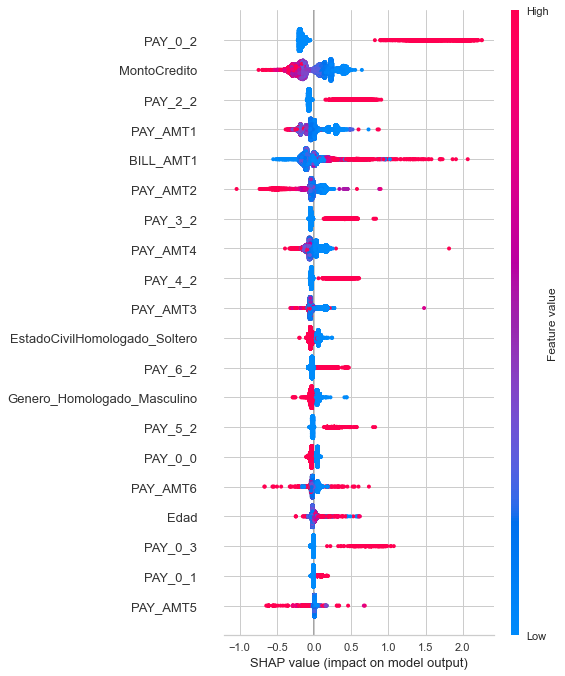

In [53]:
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()
shap.summary_plot(shap_values, x_train)

**Interación entre Features**

In [54]:
x_train.columns

Index(['PAY_5_6', 'PAY_0_6', 'PAY_6_8', 'PAY_6_5',
       'EducacionHomologada_Pregrado', 'PAY_0_5', 'PAY_5_5',
       'EstadoCivilHomologado_Soltero', 'PAY_0_8', 'PAY_3_5', 'PAY_0_7',
       'PAY_2_7', 'PAY_4_5', 'Genero_Homologado_Masculino', 'PAY_2_6',
       'PAY_3_6', 'PAY_2_5', 'PAY_6_6', 'PAY_2_4', 'PAY_6_4',
       'EducacionHomologada_Posgrado', 'PAY_3_7', 'PAY_3_4', 'PAY_5_4',
       'PAY_4_4', 'PAY_6_-1', 'PAY_0_-1', 'PAY_0_4', 'PAY_6_7', 'PAY_6_0',
       'PAY_5_0', 'PAY_5_-1', 'PAY_5_7', 'PAY_4_7', 'PAY_4_-1', 'PAY_2_-1',
       'PAY_4_0', 'PAY_3_-1', 'PAY_4_3', 'PAY_3_3', 'PAY_5_3', 'PAY_6_3',
       'PAY_3_0', 'PAY_2_3', 'PAY_0_1', 'PAY_2_0', 'PAY_0_3', 'PAY_0_0',
       'PAY_6_2', 'PAY_5_2', 'PAY_4_2', 'PAY_3_2', 'PAY_2_2', 'PAY_0_2',
       'Edad', 'BILL_AMT1', 'PAY_AMT6', 'PAY_AMT5', 'PAY_AMT3', 'PAY_AMT4',
       'PAY_AMT2', 'PAY_AMT1', 'MontoCredito'],
      dtype='object')

In [55]:
shap_values[0]

array([ 0.00000000e+00, -6.40282993e-05,  0.00000000e+00,  0.00000000e+00,
       -9.14239363e-03,  0.00000000e+00, -1.72898009e-04,  6.17271992e-02,
        0.00000000e+00,  2.76084016e-05,  0.00000000e+00, -1.14828202e-04,
        0.00000000e+00,  7.95426968e-02, -7.55802399e-05, -7.02357301e-05,
        0.00000000e+00,  0.00000000e+00,  2.45897661e-05,  0.00000000e+00,
       -5.34259919e-04,  0.00000000e+00, -4.21891679e-05, -3.73835035e-05,
       -1.47344992e-04,  9.78915512e-03,  8.23573904e-03, -9.71015105e-04,
        0.00000000e+00,  5.68920240e-05, -3.45338252e-06, -4.01609026e-06,
        0.00000000e+00, -3.49943380e-04,  0.00000000e+00,  2.62822066e-04,
       -1.86393334e-03, -7.06491154e-03, -1.54426050e-03, -2.05433728e-03,
       -5.29500157e-04, -1.50592047e-03,  0.00000000e+00, -5.75404121e-03,
       -1.22914058e-02, -6.07595878e-06, -7.24626423e-03,  3.64754859e-02,
       -2.72887033e-02, -1.85208746e-02, -3.48734652e-02, -3.50076610e-02,
       -5.78588172e-02, -

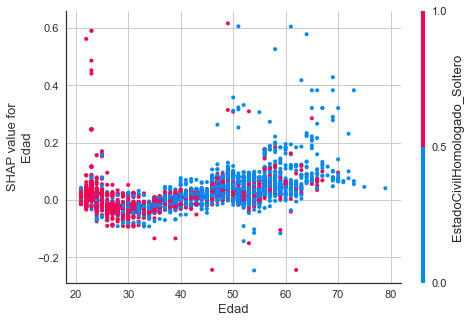

In [56]:
shap.dependence_plot("Edad",shap_values,x_train,interaction_index="EstadoCivilHomologado_Soltero")

 95%|=================== | 19880/21000 [00:16<00:00]       

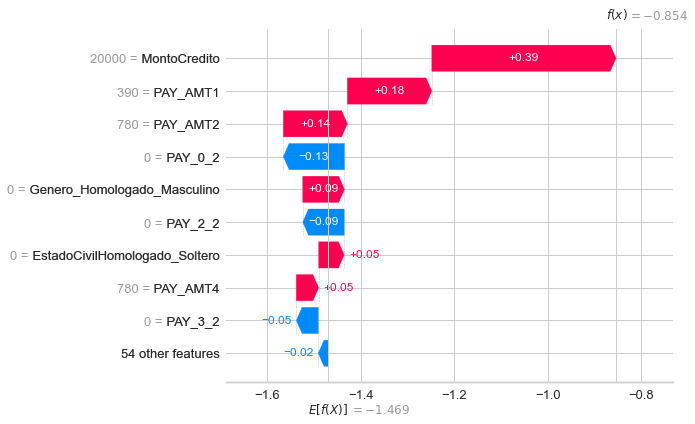

In [57]:
explainer = shap.TreeExplainer(ModeloFinal, x_train)
shap_values = explainer(x_train)
shap.plots.waterfall(shap_values[0])

## **Ordenar por Deciles (Calibrar Modelos)**

In [58]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

In [59]:
ModeloFinal

GradientBoostingClassifier(random_state=123)

In [60]:
predicciones  =ModeloFinal.predict_proba(X = x_test)
prob_positivo = predicciones[:, 1]

In [61]:
fraccion_positivos, media_prob_predicha = calibration_curve(y_test, prob_positivo, n_bins=20)

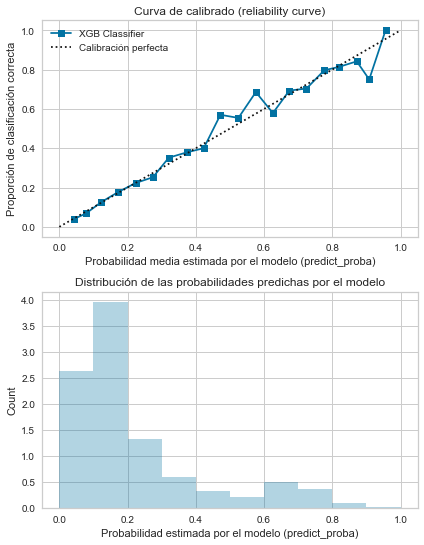

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="XGB Classifier")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(prob_positivo, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

## **Modelo clasificación calibrado**


La calibración de modelos en scikitlearn esta implementada de forma que, el objeto final, contiene tanto el modelo principal como el modelo de calibración. Esto permite que al aplicar el método .predic() los resultados ya estén corregidos.

In [63]:
ModeloFinal=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [64]:
modelo_calibrado = CalibratedClassifierCV(ModeloFinal, cv=3, method='sigmoid')

In [65]:
_ = modelo_calibrado.fit(x_train, y_train)

In [66]:
# Predicción con probabilidades calibradas
# ==============================================================================
predicciones  = modelo_calibrado.predict_proba(X = x_test)
# Se extraen las probabilidades de la clase positiva
prob_positivo = predicciones[:, 1]

In [67]:
fraccion_positivos, media_prob_predicha = calibration_curve(y_test, prob_positivo, n_bins=20)

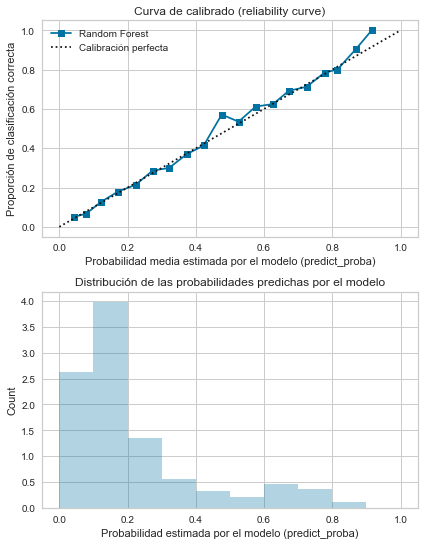

In [68]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))

axs[0].plot(media_prob_predicha, fraccion_positivos, "s-", label="Random Forest")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

axs[1].hist(prob_positivo, range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

In [69]:
Probabilidad_test=modelo_calibrado.predict_proba(x_test)
Predicciones=modelo_calibrado.predict(x_test)

In [70]:
x_test.shape

(9000, 63)

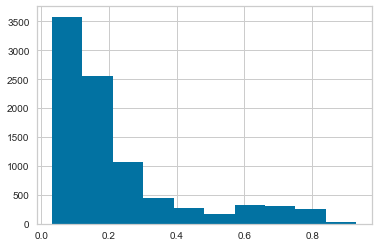

In [71]:
plt.hist(Probabilidad_test[::,1]);

In [72]:
clientes=x_test.copy()

In [73]:
clientes["Score"]=Probabilidad_test[::,1]
clientes["Prediccion"]=Predicciones
clientes["Realidad"]=y_test

In [74]:
clientes.head()

,PAY_5_6,PAY_0_6,PAY_6_8,PAY_6_5,EducacionHomologada_Pregrado,PAY_0_5,PAY_5_5,EstadoCivilHomologado_Soltero,PAY_0_8,PAY_3_5,...,PAY_AMT6,PAY_AMT5,PAY_AMT3,PAY_AMT4,PAY_AMT2,PAY_AMT1,MontoCredito,Score,Prediccion,Realidad
45,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,210000.0,0.265276,0,1
18762,0,0,0,0,0,0,0,1,0,0,...,84363.0,0.0,0.0,0.0,0.0,3000.0,420000.0,0.097524,0,0
9341,0,0,0,0,1,0,0,1,0,0,...,2000.0,1700.0,1600.0,1600.0,2310.0,3400.0,70000.0,0.119997,0,0
21814,0,0,0,0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1000.0,0.0,180000.0,0.273405,0,0
25950,0,0,0,0,0,0,0,0,0,0,...,4200.0,8000.0,388.0,110345.0,388.0,388.0,410000.0,0.128648,0,0


In [75]:
data_sorted = clientes.sort_values(by='Score', ascending=True)
data_sorted

,PAY_5_6,PAY_0_6,PAY_6_8,PAY_6_5,EducacionHomologada_Pregrado,PAY_0_5,PAY_5_5,EstadoCivilHomologado_Soltero,PAY_0_8,PAY_3_5,...,PAY_AMT6,PAY_AMT5,PAY_AMT3,PAY_AMT4,PAY_AMT2,PAY_AMT1,MontoCredito,Score,Prediccion,Realidad
9154,0,0,0,0,1,0,0,1,0,0,...,20225.0,23033.0,1068.0,3000.0,57428.0,52280.0,490000.0,0.031260,0,0
5459,0,0,0,0,0,0,0,0,0,0,...,11166.0,80601.0,48846.0,193712.0,47427.0,68536.0,360000.0,0.031486,0,0
3464,0,0,0,0,0,0,0,1,0,0,...,1241.0,59273.0,29033.0,13120.0,30084.0,42552.0,340000.0,0.031626,0,0
20688,0,0,0,0,0,0,0,1,0,0,...,11501.0,14501.0,25448.0,10015.0,29748.0,20016.0,440000.0,0.031710,0,0
3736,0,0,0,0,0,0,0,1,0,0,...,10000.0,7500.0,35002.0,10203.0,52983.0,5873.0,430000.0,0.032771,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27536,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,250000.0,0.886882,1,1
23691,0,0,0,0,1,0,0,0,0,0,...,500.0,0.0,0.0,1000.0,0.0,2415.0,20000.0,0.892800,1,1
17232,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,2395.0,4000.0,0.0,10000.0,0.897091,1,1
19485,0,0,0,0,0,0,0,0,0,0,...,318.0,534.0,1475.0,1105.0,1803.0,0.0,280000.0,0.900526,1,1


In [76]:
# Calcular el número de usuarios por decil
num_users_per_decile = len(data_sorted) // 10
# Crear una nueva columna 'decil' para indicar el decil al que pertenece cada usuario
data_sorted['decil'] = (data_sorted.reset_index().index // num_users_per_decile) + 1

900

In [78]:
data_sorted['decil'].value_counts(normalize=False)

1     900
2     900
3     900
4     900
5     900
6     900
7     900
8     900
9     900
10    900
Name: decil, dtype: int64

In [79]:
data_sorted[["decil","Score","Realidad"]]

,decil,Score,Realidad
9154,1,0.031260,0
5459,1,0.031486,0
3464,1,0.031626,0
20688,1,0.031710,0
3736,1,0.032771,0
...,...,...,...
27536,10,0.886882,1
23691,10,0.892800,1
17232,10,0.897091,1
19485,10,0.900526,1


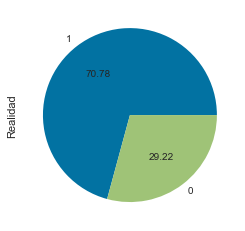

In [80]:
decil_10=data_sorted[data_sorted["decil"]==10].copy()
decil_10.Realidad.value_counts().plot(kind="pie",autopct="%.2f");

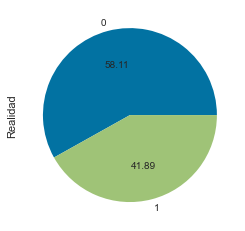

In [81]:
decil_9=data_sorted[data_sorted["decil"]==9].copy()
decil_9.Realidad.value_counts().plot(kind="pie",autopct="%.2f");

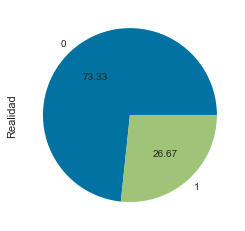

In [82]:
decil_8=data_sorted[data_sorted["decil"]==8].copy()
decil_8.Realidad.value_counts().plot(kind="pie",autopct="%.2f");

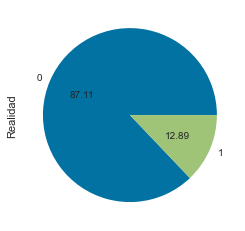

In [83]:
decil_5=data_sorted[data_sorted["decil"]==5].copy()
decil_5.Realidad.value_counts().plot(kind="pie",autopct="%.2f");

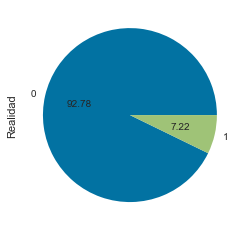

In [84]:
decil_2=data_sorted[data_sorted["decil"]==2].copy()
decil_2.Realidad.value_counts().plot(kind="pie",autopct="%.2f");

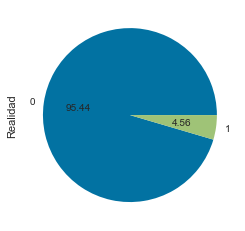

In [85]:
decil_1=data_sorted[data_sorted["decil"]==1].copy()
decil_1.Realidad.value_counts().plot(kind="pie",autopct="%.2f");

## **Exportar Modelo**

In [86]:
ModeloProductivo=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False).fit(X,y)

Accuracy: 0.8257333333333333
Reporte :               precision    recall  f1-score   support

           0       0.84      0.96      0.90     23364
           1       0.70      0.37      0.48      6636

    accuracy                           0.83     30000
   macro avg       0.77      0.66      0.69     30000
weighted avg       0.81      0.83      0.80     30000



Predicciones,0,1,All
Realidad,,,
0,22324,1040,23364
1,4188,2448,6636
All,26512,3488,30000


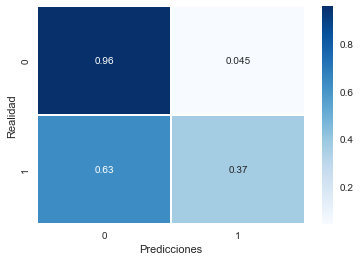

In [87]:
MetricasMatrizConfusion(y=y,Modelo=ModeloProductivo,X=X,tipo="ML")

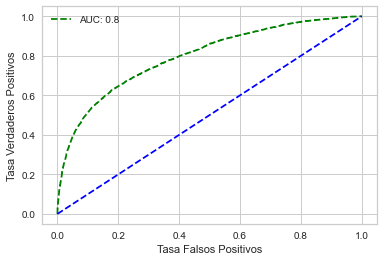

0.7964440129010499

In [88]:
curva_roc(y=y,Modelo=ModeloProductivo,X=X,tipo="ML")

In [89]:
import pickle
with open('ModeloFinalCredit.pkl', 'wb') as file:
    pickle.dump(ModeloProductivo, file)

In [91]:
x_test.to_csv("BaseNueva.csv",index=False)